In [1]:
!python ../setup.py build_ext --inplace

running build_ext
gcc -pthread -B /root/anaconda3/envs/py2/compiler_compat -Wl,--sysroot=/ -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/root/anaconda3/envs/py2/include/python2.7 -c /tmp/tmph1jl9K.cpp -o tmp/tmph1jl9K.o -std=c++14
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
gcc -pthread -B /root/anaconda3/envs/py2/compiler_compat -Wl,--sysroot=/ -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/root/anaconda3/envs/py2/include/python2.7 -c /tmp/tmpxzmB58.cpp -o tmp/tmpxzmB58.o -fvisibility=hidden
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
building 'coresets.sensitivity' extension
gcc -pthread -B /root/anaconda3/envs/py2/compiler_compat -Wl,--sysroot=/ -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/root/anaconda3/envs/py2/include -I/root/anaconda3/envs/py2/include -I/r

In [2]:
!python --version

Python 2.7.17 :: Anaconda, Inc.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
np.random.seed(42)
#from utils import datagen, plotting
#import coresets
#import algorithms
#import csv
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, scale
from math import sqrt,log
import pandas as pd
import tensorflow as tf
import timeit 

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 
#import xgboost as xgb
from sklearn.metrics import accuracy_score,classification_report,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier

In [2]:
##few func defintions
#normalize pdf area to 1:
def normaliz(array):
    normalized = []
    s=sum(array)
    for i in range(len(array)):
        n=array[i]/s
        normalized.append(n)
    return normalized
#Calculate mean
def mean(array):
    return sum(array)/float(len(array))
 
# Calculate the standard deviation of a list of numbers
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)
#kl divergence
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    c = 0
    for i in range(len(p)):
        if(p[i]!=0) and (q[i]!=0):
        #if(p[i]!=0):
            c=c+p[i]*log(p[i]/q[i])     
    return c
    #return np.sum(np.where(p != 0 , p * np.log(p / q), 0))
    
def dist(x,y):   
    return sqrt(np.sum((x-y)**2))

def cost(data,clusters):
    k=len(clusters)
    min_dist = []
    for i in range(len(data)):
        d = []
        for j in range(k):
            d.append(dist(data[i],clusters[j]))
        min_dist.append(np.min(d))
    cost = sum(min_dist)
    return cost
#kl divergence
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    c = 0
    for i in range(len(p)):
        if(p[i]!=0) and (q[i]!=0):
        #if(p[i]!=0):
            c=c+p[i]*log(p[i]/q[i])     
    return c
    #return np.sum(np.where(p != 0 , p * np.log(p / q), 0))
    

In [3]:
#window kernel
def window_function(x_vec, unit_len=1):
    for row in x_vec:
        if np.abs(row) > (unit_len/2):
            return 0
    return 1

def kernel_func(h, x, x_i):
    assert (x.shape == x_i.shape), 'vectors x and x_i must have the same dimensions'
    return (x - x_i) / h

def window_func(x_vec, h):
   
    for row in x_vec:
        if np.abs(row) > 0.5:
            #print(row)
            return 0
    return 1
    #dist=sqrt(np.sum((x_vec)**2))
    #print("distance="+str(dist))
    #if dist > 0.5:
     #   return 0
    #else: 
     #   return 1

#main parzen window function
def parzen_estimate(x_samples, point_x, h, d):
    
    k_n = 0
    for row in x_samples:
        x_i = kernel_func(h=h, x=point_x, x_i=row[:,np.newaxis])
        #x_i = kernel_func(h=h, x=point_x, x_i=row)
        k_n += window_func(x_i, h=h)
        
    #print(k_n)
    temp1=float(k_n)/(h**d)
    temp2=temp1/len(x_samples)
    return temp2
    #return (float(k_n) / len(x_samples)) / (h**d)
    
def covar(data):
    mean_data=data.mean(axis=0)   
    cov=np.zeros((len(mean_data),len(mean_data)))
    for i in range(len(mean_data)):
        for j in range(len(mean_data)):
            for k in range(len(data)):
                cov[i][j]=cov[i][j]+((data[k][i]-mean_data[i])*(data[k][j]-mean_data[j]))
            cov[i][j]=cov[i][j]/(len(data)-1)
    return cov  

def show_img(data,idx):
    data *= 255
    im=np.reshape(data[idx],(28,28))
    plt.imshow(im,cmap='Greys')

In [4]:
#import MNIST train set
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_df=pd.read_csv('mnist_train.csv', sep=',')

#convert df to np
x_train_temp_np=x_train_df.to_numpy()

#dividing into labels and data 
x_train_data=x_train_temp_np[:, 1:785]
x_train_label=x_train_temp_np[:,[0]]


In [5]:
#import MNIST test set
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test_df=pd.read_csv('mnist_test.csv', sep=',')

#convert df to np
x_test_temp_np=x_test_df.to_numpy()

#dividing into labels and data 
x_test_data=x_test_temp_np[:, 1:785]
x_test_label=x_test_temp_np[:,[0]]



In [6]:
#normalizing both train and test data with max RGB value
x_train_data_norm=x_train_data.astype('float')
x_test_data_norm=x_test_data.astype('float')
x_train_data_norm/=255
x_test_data_norm/=255
data_length=20000
b=int(sqrt(data_length))
print(b)

141


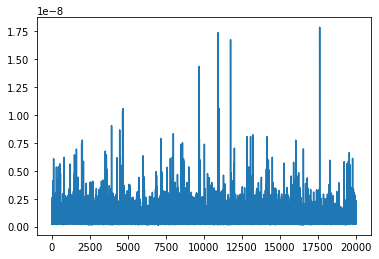

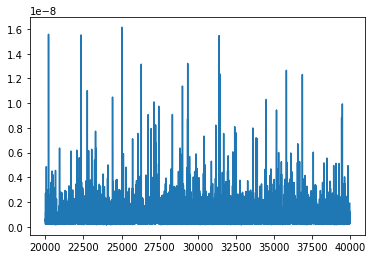

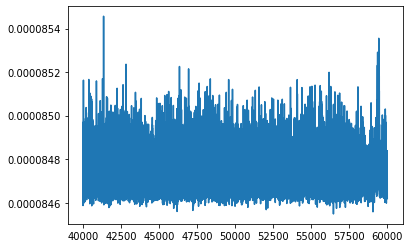

In [7]:
df=pd.read_csv('MNIST_KL20.csv')#load 20K
kl_load20=df.to_numpy()
plt.plot(kl_load20)
plt.show()
df=pd.read_csv('MNIST_KL2040.csv')#load 20Kto40k
kl_load2040=df.to_numpy()
plt.plot(range(20000,40000),kl_load2040)
plt.show()
df=pd.read_csv('MNIST_KL4060.csv')#load 40Kto60k
kl_load4060=df.to_numpy()
plt.plot(range(40000,60000),kl_load4060)
plt.show()

In [16]:

full_start = timeit.timeit()
svm = SVC(kernel = 'linear', C = 1).fit(x_train_data_norm[0:60000], x_train_label[0:60000].ravel())
full_end = timeit.timeit()
score_svm_fulldata=svm.score(x_test_data_norm, x_test_label)

fd_runtime = abs(full_end-full_start)

print("Score of SVM with full data :"+str(score_svm_fulldata))
print("Full data runtime: "+str(fd_runtime))

Score of SVM with full data :0.8731
Full data runtime: 0.0001109000004362315


In [8]:
#coreset procedure begins
#appending the KL records
temp=np.vstack((kl_load20,kl_load2040))
kl_load_full=np.vstack((temp,kl_load4060))

#append label and KL weight and sort
x_data_label_merge=np.column_stack((x_train_data_norm[0:60000],x_train_label[0:60000]))
x_data_label_kl_merge=np.column_stack((x_data_label_merge,kl_load_full))
x_data_label_kl_merge_sort=x_data_label_kl_merge[x_data_label_kl_merge[:,785].argsort()]


Following digit to be recognized:


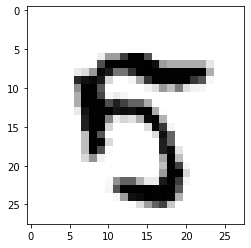

In [9]:
index = 2001 #, 1890,3001
print("Following digit to be recognized:")
show_img(x_test_data_norm,index)

In [10]:
perc=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#perc=[0.1]

svm_acc = []
time_coreset = []
svm_coreset_model=[0]*len(perc)
print("Begin test: ")
for i in range(len(perc)):
    
    coreset_size=int(perc[i]*len(kl_load_full))
    coreset_data_label=x_data_label_kl_merge_sort[(60000-coreset_size):60000]
    coreset_data=coreset_data_label[:, 0:784]
    coreset_label=coreset_data_label[:,[784]]
    print("Size of Coreset: " +str(len(coreset_data)))
    
    #train svm with coreset
    start = timeit.timeit()
    svm_coreset_model[i] = SVC(kernel = 'linear', C = 1).fit(coreset_data, coreset_label.ravel())
    end = timeit.timeit()
    
    #prediction and score
    pred = svm_coreset_model[i].predict(x_test_data_norm)
    #score_svm_coreset=svm_coreset.score(x_test_data_norm, x_test_label)
    score_svm_coreset=accuracy_score(x_test_label, pred)
    svm_acc.append(score_svm_coreset)
    
    #test model on chosen image
    
    result=svm_coreset_model[i].predict([x_test_data_norm[index]])
    print("Test Label: "+str(x_test_label[index]))
    print("Predicted label: "+str(result))
    
    
    t=abs(end-start)
    time_coreset.append(t)
    
    print("Ratio done: "+str(perc[i]))
    #print("Runtime: "+str(t))
    print("SVM_Accuracy: "+str(score_svm_coreset))
    print("=====================")



Begin test: 
Size of Coreset: 6000
Test Label: [5]
Predicted label: [8.]
Ratio done: 0.1
SVM_Accuracy: 0.7629
Size of Coreset: 12000
Test Label: [5]
Predicted label: [8.]
Ratio done: 0.2
SVM_Accuracy: 0.7833
Size of Coreset: 18000
Test Label: [5]
Predicted label: [8.]
Ratio done: 0.3
SVM_Accuracy: 0.7837
Size of Coreset: 24000
Test Label: [5]
Predicted label: [8.]
Ratio done: 0.4
SVM_Accuracy: 0.8365
Size of Coreset: 30000
Test Label: [5]
Predicted label: [8.]
Ratio done: 0.5
SVM_Accuracy: 0.8526
Size of Coreset: 36000
Test Label: [5]
Predicted label: [8.]
Ratio done: 0.6
SVM_Accuracy: 0.8628
Size of Coreset: 42000
Test Label: [5]
Predicted label: [8.]
Ratio done: 0.7
SVM_Accuracy: 0.8712
Size of Coreset: 48000
Test Label: [5]
Predicted label: [8.]
Ratio done: 0.8
SVM_Accuracy: 0.8789
Size of Coreset: 54000
Test Label: [5]
Predicted label: [8.]
Ratio done: 0.9
SVM_Accuracy: 0.8765


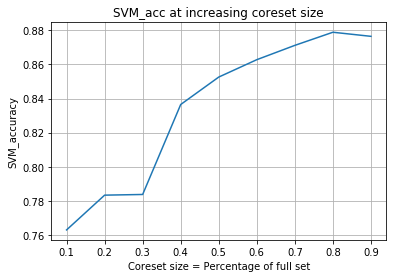

In [11]:

plt.grid(True)
plt.xlabel('Coreset size = Percentage of full set')
plt.ylabel('SVM_accuracy')
plt.title('SVM_acc at increasing coreset size')
plt.plot(perc,svm_acc,label="Coreset accuracy")
#plt.plot(perc,f_acc,label="Full set accuracy level")
#plt.legend(loc="bottom right")
plt.savefig("Svm_acc.png")

In [13]:
svm_acc

[0.7629, 0.7833, 0.7837, 0.8365, 0.8526, 0.8628, 0.8712, 0.8789, 0.8765]

Following digit to be recognized:


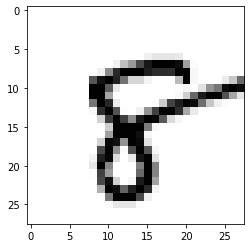

Test Sample No: 8440
Test sample: [8]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Test Label: [8]
All predictions: 
[array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.])]
Following digit to be recognized:


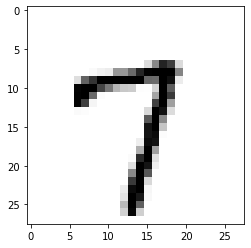

Test Sample No: 1705
Test sample: [7]
Predicted Label: [7.]
Predicted Label: [9.]
Predicted Label: [9.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Test Label: [7]
All predictions: 
[array([7.]), array([9.]), array([9.]), array([7.]), array([7.]), array([7.]), array([7.]), array([7.]), array([7.])]
Following digit to be recognized:


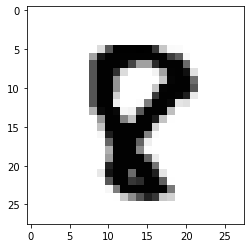

Test Sample No: 4390
Test sample: [8]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Test Label: [8]
All predictions: 
[array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.])]
Following digit to be recognized:


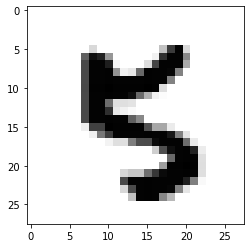

Test Sample No: 9382
Test sample: [5]
Predicted Label: [5.]
Predicted Label: [5.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Test Label: [5]
All predictions: 
[array([5.]), array([5.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.])]
Following digit to be recognized:


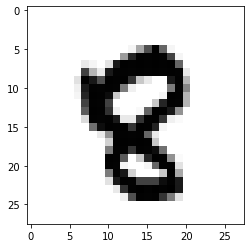

Test Sample No: 6395
Test sample: [8]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Predicted Label: [8.]
Test Label: [8]
All predictions: 
[array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.]), array([8.])]
Following digit to be recognized:


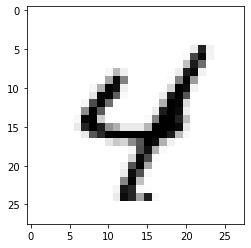

Test Sample No: 8395
Test sample: [4]
Predicted Label: [4.]
Predicted Label: [4.]
Predicted Label: [4.]
Predicted Label: [4.]
Predicted Label: [4.]
Predicted Label: [4.]
Predicted Label: [4.]
Predicted Label: [4.]
Predicted Label: [4.]
Test Label: [4]
All predictions: 
[array([4.]), array([4.]), array([4.]), array([4.]), array([4.]), array([4.]), array([4.]), array([4.]), array([4.])]
Following digit to be recognized:


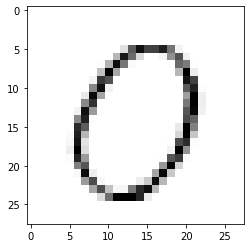

Test Sample No: 2479
Test sample: [0]
Predicted Label: [0.]
Predicted Label: [0.]
Predicted Label: [0.]
Predicted Label: [0.]
Predicted Label: [0.]
Predicted Label: [0.]
Predicted Label: [0.]
Predicted Label: [0.]
Predicted Label: [0.]
Test Label: [0]
All predictions: 
[array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
Following digit to be recognized:


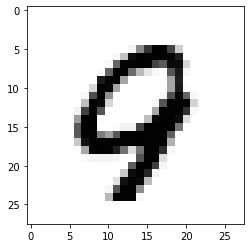

Test Sample No: 6507
Test sample: [9]
Predicted Label: [9.]
Predicted Label: [9.]
Predicted Label: [9.]
Predicted Label: [9.]
Predicted Label: [4.]
Predicted Label: [9.]
Predicted Label: [9.]
Predicted Label: [9.]
Predicted Label: [9.]
Test Label: [9]
All predictions: 
[array([9.]), array([9.]), array([9.]), array([9.]), array([4.]), array([9.]), array([9.]), array([9.]), array([9.])]
Following digit to be recognized:


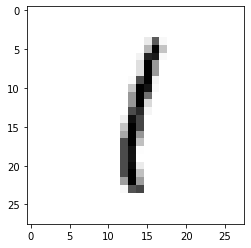

Test Sample No: 4428
Test sample: [1]
Predicted Label: [1.]
Predicted Label: [1.]
Predicted Label: [8.]
Predicted Label: [1.]
Predicted Label: [1.]
Predicted Label: [1.]
Predicted Label: [1.]
Predicted Label: [1.]
Predicted Label: [1.]
Test Label: [1]
All predictions: 
[array([1.]), array([1.]), array([8.]), array([1.]), array([1.]), array([1.]), array([1.]), array([1.]), array([1.])]
Following digit to be recognized:


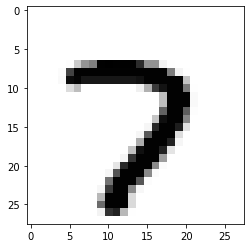

Test Sample No: 5334
Test sample: [7]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Predicted Label: [7.]
Test Label: [7]
All predictions: 
[array([7.]), array([7.]), array([7.]), array([7.]), array([7.]), array([7.]), array([7.]), array([7.]), array([7.])]


In [14]:
import random


for i in range(0,10):
    index=random.randint(0,10000)
    #index=4509
    print("Following digit to be recognized:")
    show_img(x_test_data_norm,index)
    plt.show()
    print("Test Sample No: "+str(index))
    print("Test sample: "+str(x_test_label[index]))
    pred_label = []
    coreset_svm_acc = []
    
    for j in range(len(perc)):
        pred = svm_coreset_model[j].predict([x_test_data_norm[index]])
        print("Predicted Label: "+str(pred))
        pred_label.append(pred)
        #print("Predicted Label with "+str(perc[j])+" ratio having accuracy "+str(score_svm_coreset[j])+" : "+str(pred_label))
    print("========================")
    print("Test Label: "+str(x_test_label[index]))
    print("All predictions: ")    
    print(pred_label) 